# Import Software Libraries

In [1]:
import warnings  # Suppress warnings

warnings.filterwarnings("ignore")
import datetime as dt  # Work with datetime types.
import os  # Interact with the operating system.
import sys  # Read system parameters.
from io import StringIO  # Read and write strings as files
from urllib.parse import urlparse  # Parse url and extract path component

import matplotlib
import matplotlib.pyplot as plt
import numpy as np  # Work with multi-dimensional arrays and matrices.
import pandas as pd  # Manipulate and analyze data frames.
import requests  # Send HTTP requests
import sklearn  # Perform feature engineering and machine learning.
import statsmodels  # Perform statistical modeling.

# Summarize software libraries used.
print("Libraries used in this project:")
print("- NumPy {}".format(np.__version__))
print("- pandas {}".format(pd.__version__))
print("- scikit-learn {}".format(sklearn.__version__))
print("- statsmodels {}".format(statsmodels.__version__))
print("- Matplotlib {}".format(matplotlib.__version__))
print("- Python {}\n".format(sys.version))

Libraries used in this project:
- NumPy 1.24.3
- pandas 2.0.3
- scikit-learn 1.3.2
- statsmodels 0.14.1
- Matplotlib 3.7.2
- Python 3.8.18 | packaged by conda-forge | (default, Dec 23 2023, 17:23:49) 
[Clang 15.0.7 ]



# Load Dataset

In [2]:
# Capture URL
url = "https://raw.githubusercontent.com/tyrantdavis/datasets/refs/heads/main/elect_net_gen_solar.csv"
request = requests.get(url).text

# Save as dataframe and copy
original = pd.read_csv(StringIO(request), index_col="Date")
df = original.copy()

# Parse URL
parsed_url = urlparse(url)
path = parsed_url.path
filename = os.path.basename(path)


print(f"Loaded {len(df)} records from {filename}.")
print(df.tail())

Loaded 591 records from elect_net_gen_solar.csv.
          ElectNetGen
Date                 
2021 11      7873.778
2021 12      6354.878
2022 01      8003.896
2022 02      9202.560
2022 03     11890.566


# Get Acquainted with the Dataset

In [3]:
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
Index: 591 entries, 1973 01  to 2022 03 
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ElectNetGen  459 non-null    float64
dtypes: float64(1)
memory usage: 9.2+ KB
None


,ElectNetGen
Date,
1973 01,NaN
1973 02,NaN
1973 03,NaN
1973 04,NaN
1973 05,NaN
...,...
2021 11,7873.778
2021 12,6354.878
2022 01,8003.896


**Spotlights**

• The data frame consists of a single column named ElectNetGen.  
• ElectNetGen contains floating point numbers.  
• The data frame has a Date index that captures the month and year of each record. This will be converted to a datetime format for simplicity.  
• The net electricity generated is quantified in gigawatt-hours (GWh), equivalent to one million kilowatt-hours (kWh).  
• Some of the earlier years have missing entries. This is understandable as solar power is a relatively recent development. However, these missing values will need to be addressed. 

# Process `Date` Index to Datetime Format Conversion 

In [4]:
df.index = pd.to_datetime(df.index, format="mixed").to_period("M")  # Specify months.
df.head()
print("The Date index is now properly formatted.")

The Date index is now properly formatted.


# Plot Net Electricity Generation

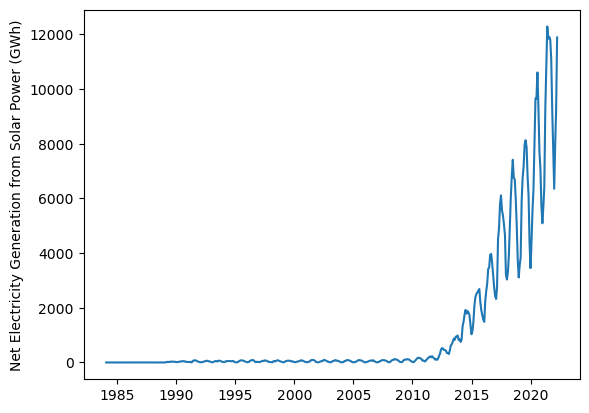

In [5]:
plt.plot_date(df.index, df["ElectNetGen"], fmt="-")
plt.ylabel("Net Electricity Generation from Solar Power (GWh)");

**Spotlights** 

There has been a notable increase in solar energy usage over the years, with the most significant growth occurring around the mid-2010s. Given that prior years experienced minimal to no electricity generation from solar power, it may be prudent to exclude that data from the analysis. Therefore, all measurements recorded before 2015 will be treated as outliers.

# Eliminate Months with Minimal Solar-Power Generation

In [6]:
# Remove designated outliers
df = df.loc[df.index.year >= 2015]
df

,ElectNetGen
Date,
2015-01,1155.351
2015-02,1483.554
2015-03,2072.257
2015-04,2379.118
2015-05,2504.149
...,...
2021-11,7873.778
2021-12,6354.878
2022-01,8003.896


The dataset now encompasses measurements from January 2015 onward. This effectively addressed previous issues with missing data as well.

# Analyze Seasonal Patterns Present in the Dataset.

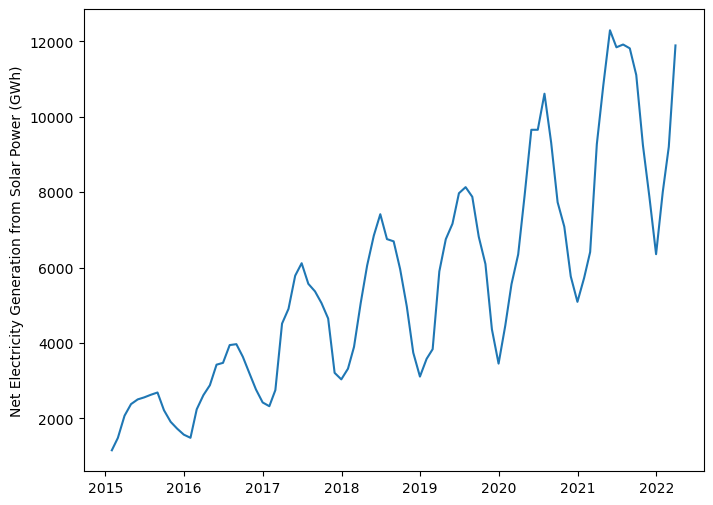

In [7]:
fig = plt.figure(figsize=(8, 6))
plt.plot_date(df.index, df["ElectNetGen"], fmt="-")
plt.ylabel("Net Electricity Generation from Solar Power (GWh)");

**Spotlights** 

The analysis of the graph indicates that the electrical energy readings exhibit a yearly cyclical pattern. This is refered to as [seasonality](https://en.wikipedia.org/wiki/Seasonality) where a pattern recurs over a specified number of time periods.  At the outset of the year, coinciding with winter in the Northern Hemisphere, the usage levels are relatively low. Subsequently, there is a notable increase in consumption, peaking around the mid-year point, which corresponds to summer in the Northern Hemisphere. Following this peak, the usage begins to decline in the latter months of the year. This trend appears to repeat in subsequent years.

To validate this observation, a more rigorous statistical analysis will be undertaken.

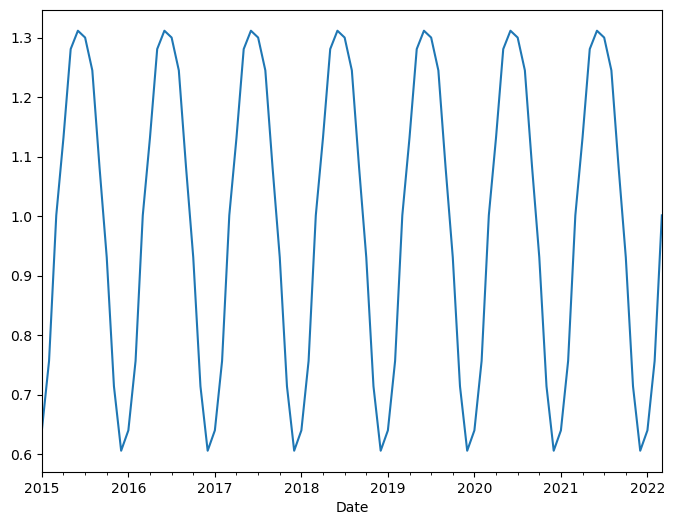

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Obtain seasonality decomposition using moving averages.
seasonal_decomp = seasonal_decompose(
    df["ElectNetGen"], model="multiplicative", period=12  # Changing magnitude.
)

fig = plt.figure(figsize=(8, 6))
seasonal_decomp.seasonal.plot()
plt.show();

- The statsmodels seasonal_decompose() function to extracts seasonal characteristics from the dataset. This method is referred to as decomposition.

- A multiplicative model is applied instead of an additive one. The additive model is appropriate when the degree of seasonality remains fairly consistent over time. In contrast, a multiplicative model is suitable when the seasonal variations either increase or decrease over time. Given that the seasonal trend in the electricity generation data is on the rise, a multiplicative approach is chosen.

**NOTE**: It is important to note that this does not pertain to the overall upward trend of values, but rather indicates that the "peaks" and "valleys" within each season are growing in proportion over time.

- The **period** parameter defines the seasonal period. Since the assumption is that the seasonal pattern occurs annually, this period is identified as consisting of 12 time intervals (i.e., 12 months).

- The step on line 9 extracts solely the seasonal component from the decomposition results. Although there are additional statistical metrics related to decomposition, this particular one is adequate.

**Spotlight** 

Every year shows a steady variation, beginning with a gradual rise at the start of the year, reaching its high point mid-year, and then gradually declining towards a low point by the year's end. This pattern typically aligns with the peaks and troughs observed in the raw data plot, reinforcing the existence of a 12-month seasonal cycle.

# Split the Dataset

This analysis will utilize a single variable for prediction, necessitating the creation of a unified training and testing dataset.  Unlike problems addressed by linear regression or other supervised algorithms, it is important to maintain the integrity of the time series during the split, hence the use of shuffle = False.  This approach ensures that the test set comprises the final portion of the dataset, sequentially following the training set.

The argument train_size = 80 specifies the allocation of a designated number of rows to the training set, with the remaining observations reserved for the test set.  While a more conventional split of 60% training and 40% testing is often used for larger datasets, this specific dataset experiences challenges in achieving stationarity with a limited number of training observations.

In [9]:
from sklearn.model_selection import train_test_split

# There is only one variable, it is sufficient to perform a single set of train/test splits.
# Partition most recent data for testing purposes.
X_train, X_test = train_test_split(df, train_size=80, shuffle=False)

# Contrast original data to training and testing sets.
print(f"Original set:      {df.shape}")
print("------------------------------")
print(f"Training features: {X_train.shape}")
print(f"Testing features:  {X_test.shape}")

Original set:      (87, 1)
------------------------------
Training features: (80, 1)
Testing features:  (7, 1)


# Implement Seasonal ARIMA Model

The next step is to use the **ARIMA()** class from **statsmodels** to generate the model 

In the case of the non-seasonal **order** argument:

- The lag count is set to 1 (p, representing autoregression).  
- The observations are differenced once (d, denoting integration).  
- The number of lagged error terms is 1 (q, indicating moving average).  
- The values provided are somewhat random and not definitively optimal, but they serve as a reasonable initial reference.

In the **seasonal_order** parameter:

- The values for p, d, and q remain identical.  
- The period is set to 12, which accommodates the yearly context of the electrical energy measurements you previously validated.  
- **_model_fit_** executes the model fitting. The training data was provided as the initial argument in ARIMA(), so there’s no need to specify it again here.

In [10]:
from statsmodels.tsa.arima.model import ARIMA

# Values for p, d, and q are arbitrary.
forecast_model = ARIMA(
    X_train["ElectNetGen"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)
)

model_fit = forecast_model.fit(method_kwargs={"warn_convergence": False})
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                      ElectNetGen   No. Observations:                   80
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -513.687
Date:                          Sat, 07 Dec 2024   AIC                           1037.375
Time:                                  21:54:18   BIC                           1048.398
Sample:                              01-31-2015   HQIC                          1041.737
                                   - 08-31-2021                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6343      0.215      2.952      0.003       0.213       1.055
ma.L1         -0.8838      0.131     -6.732      0.000      -1.141      -0.627
ar.S.L12      -0.9406      0.160     -5.879      0.000      -1.254      -0.627
ma.S.L12       0.7601      0.353      2.151      0.032       0.067       1.453
sigma2      2.473e+05   4.95e+04      4.998      0.000     1.5e+05    3.44e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.75
Prob(Q):                              0.99   Prob(JB):                         0.09
Heteroskedasticity (H):               2.34   Skew:                             0.63
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Please note** that the call to fit() is quelling a warning regarding the model's inability to optimize one of the statistical results. Despite this warning, the model remains valuable and applicable.

**Spotlights** 

The output provides comprehensive insights regarding the model that has been recently trained, including:

- The AR (Autoregressive), I (Integrated), and MA (Moving Average) hyperparameters for both non-seasonal and seasonal components.
- The span of the time series present in the training set, referred to as the "sample."
- Model parameters (coefficients) associated with the autoregressive lag and moving average for both non-seasonal and seasonal aspects. Given that a value of 1 was assigned to each hyperparameter, there is only a single lag and one moving average for each component.
- Standard error and z-score values related to the lags and moving averages.
- p-values for the lags and moving averages, where values below the significance level of 0.05 are considered favorable. **This indicates the rejection of the null hypothesis that the lags and moving averages exert no significant influence on the model**. Since these values are indeed below 0.05, it can be confidently asserted that they have a meaningful impact on the model.
- Skewness and kurtosis values for the dataset.
- Additional relevant information.

# Forecast Electricity Generation Utilizing the Test Set

The next step will generate predictions that correspond to the time frame present in the test set.

- The **start** parameter establishes the beginning of the prediction at the same time point as the commencement of the testing set. Similarly.
- The **end** parameter does the same for the final value.

In [11]:
# Generate forecasts that align with the duration present in the test set.
predictions = model_fit.predict(start=X_test.index[0], end=X_test.index[-1])
predictions

2021-09    10117.965019
2021-10     9452.071859
2021-11     7785.946426
2021-12     7056.844581
2022-01     7802.637055
2022-02     8772.878581
2022-03    10759.825117
Freq: M, Name: predicted_mean, dtype: float64

**Spotlight** 

The model generated these predictions for the same timeframe as the testing set, which spans from **September 2021** to **March 2022**, encompassing the last 7 months of the complete dataset.

# Determine the Error Between the Predicted Values and the Actual Values.

In [12]:
from sklearn.metrics import mean_squared_error as mse

cost = mse(X_test, predictions, squared=False)
print("Cost (root mean squared error): {:.2f}".format(cost))

Cost (root mean squared error): 657.36


**Spotlight** 

The **RMSE stands at 657.36**. It’s important to remember that each data point was measured in thousands of GWh.

# Plot Prediction Residuals 

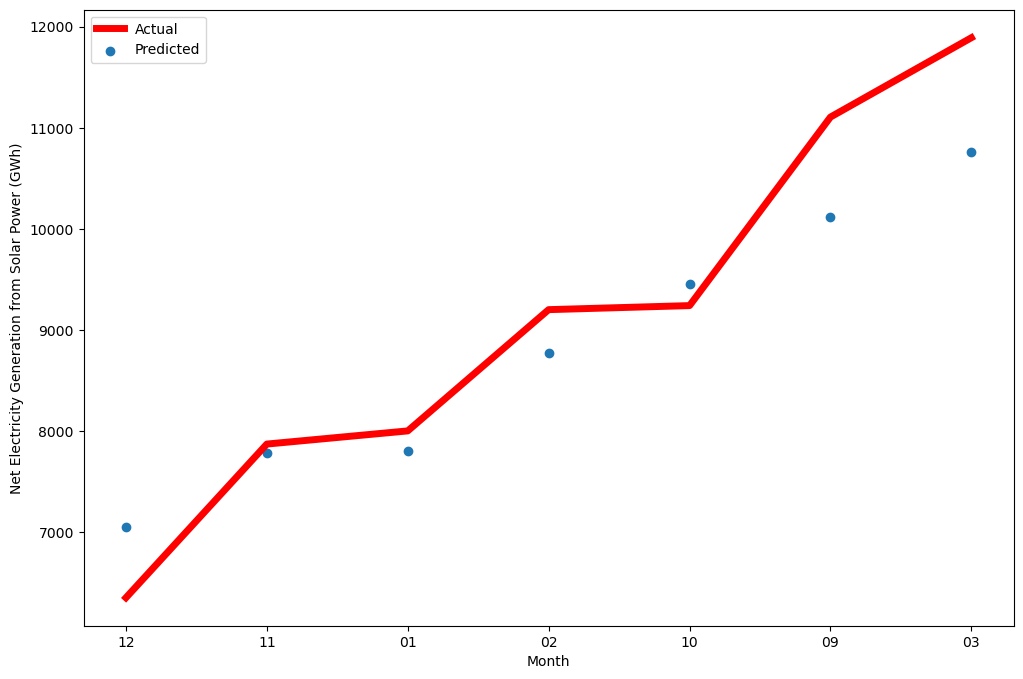

In [13]:
def graph_prediction_residuals(X_test, predictions):
    """Plots residuals of predicted electricity generation vs. actual electricity generation on test set."""

    # Create data frame for plotting residuals.
    residual_dataframe = pd.DataFrame()

    residual_dataframe["ElectNetGen"] = X_test
    residual_dataframe["ElectNetGen_Pred"] = predictions
    residual_dataframe["residuals"] = (
        residual_dataframe["ElectNetGen"] - residual_dataframe["ElectNetGen_Pred"]
    )
    residual_dataframe = residual_dataframe.sort_values("ElectNetGen")
    residual_dataframe["month_num"] = list(
        residual_dataframe.index.astype(str).str[-2:]
    )

    plt.figure(figsize=(12, 8))

    plt.plot(
        residual_dataframe["month_num"],
        residual_dataframe["ElectNetGen"],
        color="red",
        linewidth=5,
    )
    plt.scatter(residual_dataframe["month_num"], residual_dataframe["ElectNetGen_Pred"])

    plt.legend(["Actual", "Predicted"])
    plt.ylabel("Net Electricity Generation from Solar Power (GWh)")
    plt.xlabel("Month")
    plt.show()


graph_prediction_residuals(X_test, predictions.values)

- The dataset has been organized based on the actual electricity produced each month in the test set, represented by the red line.
- The forecasted electrical energy generation for each monthly assessment is depicted as a blue dot in a scatter plot. The greater the distance of the dot from the line, the larger the discrepancy between the predicted and actual figures.
- It is evident that some predictions are relatively close to the line, such as month 11 (November 2021) and month 01 (January 2022).
- Conversely, some predictions are more distant, like month 09 (September 2021) and month 03 (March 2022).

# Forecast Future Electricity Generation Values

**Forecast one year out** 

In [14]:
forecasts = model_fit.predict(start="2022-04", end="2023-03")

**Create new data frame for forecasting results**

The next step is to create a new data frame designed to store the forecasted values along with date values for the historical dates. This will simplify the plotting process.

In [15]:
forecasts = forecasts.rename("ElectNetGen")
forecasts_dataframe = pd.DataFrame(
    forecasts, index=forecasts.index, columns=["ElectNetGen"]
)

**Display Forecasts** 

The projected electrical energy production figures (in GWh) for the upcoming 12 months in the U.S..

In [16]:
forecasts_dataframe.head(12)

,ElectNetGen
2022-04,12474.756751
2022-05,14213.995501
2022-06,13699.266752
2022-07,14052.296620
2022-08,13623.330043
2022-09,11883.337936
2022-10,11139.780986
2022-11,9740.030456
2022-12,9023.381319
2023-01,9639.802747


# Display the Forecasting Trend

The final stage is to analyze the emerging trends in the forecasts. A **green line will graph the predicted values** as a line. A **black line will graph historical data** in a line format.

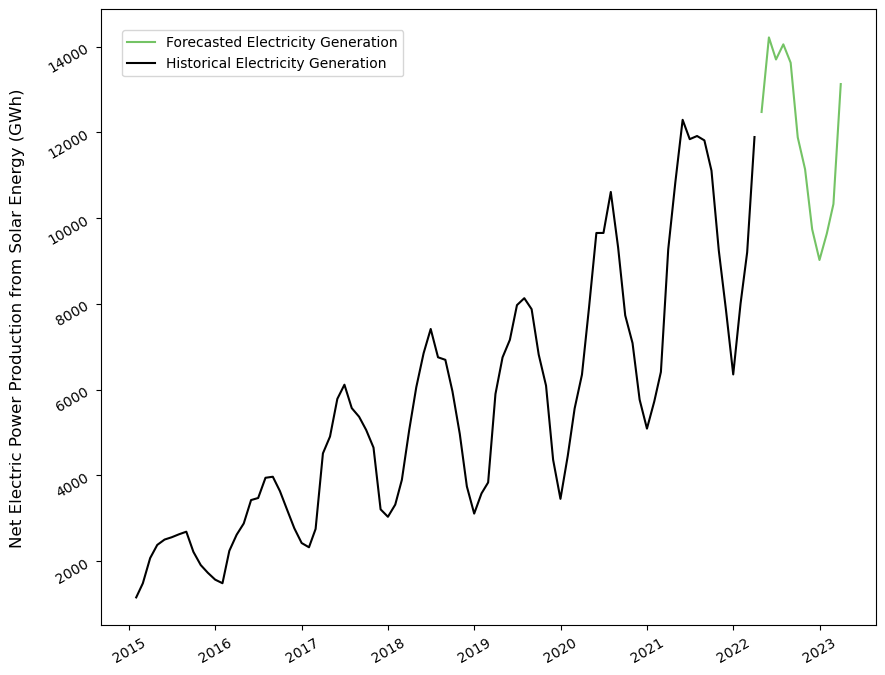

In [17]:
fig = plt.figure(figsize=(10, 8))
ax = fig.subplots(1, 1)

# Graph predicted values - GREEN LINE
ax.plot_date(
    forecasts_dataframe.index,
    forecasts_dataframe["ElectNetGen"],
    fmt="-",
    color="#74C365",
    label="Forecasted Electricity Generation",
)

# Graph historical data - BLACK LINE
ax.plot_date(
    df.index,
    df["ElectNetGen"],
    fmt="-",
    color="black",
    label="Historical Electricity Generation",
)

ax.tick_params(labelrotation=30)
ax.set_ylabel(
    "Net Electric Power Production from Solar Energy (GWh)", labelpad=15, fontsize=12
)

ax.legend(loc="upper left", frameon=True, borderaxespad=1.5);

**Spotlights** 

- Following March 2022, the green line continued with the predicted power generation figures for the next year.
- The model indicated that electrical energy generation from solar power would peak in the middle of 2022 at roughly 14,000 GWh, then dip to around 9,000 GWh at the end of the year before rising again in 2023. As in previous years, **solar power usage followed a seasonal but overall rising trend**.